### Source : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#20topicdistributionacrossdocuments

In [15]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
import re
import numpy as np
import pandas as pd
import random
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [17]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [18]:
# Import Dataset
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [244]:
# Create new culumn inicating total number of categories per comment
df['sum'] = df['toxic']+df['severe_toxic']+df['obscene']+df['threat']+df['insult']+df['identity_hate']



In [245]:
# Sempling 2% of comments without any categories in order to have relatively balanced dataset to create corpus

s0 = df['sum'][df['sum'] == 0 ].sample(16000).index

df0 = df.loc[s0]
df1 = df[df['sum'] != 0]

df1 = df1.append(df0, ignore_index=0)


s0 = df1.sample(2000).index

df_test = df1.loc[s0]
df1 = df1.drop(s0, axis = 0)


df_test.describe



<bound method NDFrame.describe of                       id                                       comment_text  \
93481   f9f0a212927beec5  Reasonable request \n\nI am going to piss on y...   
135365  d3f8a7b8dd34ef10  which one you faild the exams or the names? I'...   
36204   60b8ea4f35cf2943  Yep, Shiguy. That's me. David Hodges.\nI have ...   
73331   c432831f61aabd66  "\n\n Urartu case \n\nFirst of all, I would li...   
8174    15be8bc0f18b733c  Stop screwing with my edits, copyright is for ...   
...                  ...                                                ...   
98719   1015a53128cc7365                          Your edits to Whissendine   
117118  71e565c1d751c251              Take a look at the answer to FAQ Q22.   
150713  70bcdaa49c0ce2d3  Hmmm... \n\nSo you decide not to answer my que...   
54294   910eab6135694fd2  REDIRECT Talk:List of heads of government of t...   
42458   714f742709971c12  Begging \n\nWhy are you being such a gimp? Jim...   

        toxic  se

In [246]:
df1.describe

<bound method NDFrame.describe of                       id                                       comment_text  \
6       0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
12      0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......   
16      0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...   
42      001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...   
43      00190820581d90ce           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   
...                  ...                                                ...   
27348   4864440b40a076f0  Please: +ca\nI have created this article in my...   
30621   51494cb8fb2d942e  " — Preceding unsigned comment added by  (talk...   
48797   82768dc271b75d2b  Thanks.  I was just curious because I can't he...   
150428  6c227d188c88856d  "\nIN fact what I want is that the article con...   
69569   ba1312cfd4fca6de  And Thank you for being such a kind, patient a...   

        toxic  se

In [247]:
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3


(array([14967.,  5984.,     0.,  3277.,     0.,  3954.,  1654.,     0.,
          359.,    30.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

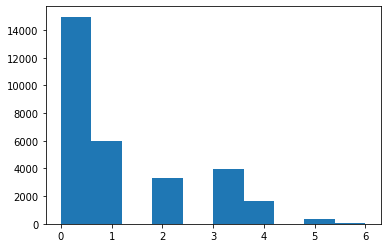

In [248]:
plt.hist(df1['sum'])

In [249]:
# Convert to list
data = df1.comment_text.values.tolist()
pprint(data[:1])

['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK']


In [419]:
df1_alt = df1[df1['sum']!=0]
df1_alt.describe
# Convert to list
data_alt = df1_alt.comment_text.values.tolist()
pprint(data_alt[:1])


['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK']


In [420]:
#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

data_alt_words = list(sent_to_words(data_alt))

print(data_alt_words[:1])

[['cocksucker', 'before', 'you', 'piss', 'around', 'on', 'my', 'work']]


In [251]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['cocksucker', 'before', 'you', 'piss', 'around', 'on', 'my', 'work']


In [421]:
# Build the bigram and trigram models
bigram_alt = gensim.models.Phrases(data_alt_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_alt = gensim.models.Phrases(bigram_alt[data_alt_words], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram_alt)
trigram_mod = gensim.models.phrases.Phraser(trigram_alt)

In [253]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [254]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams) #, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['piss', 'work']]


In [422]:
# Remove Stop Words
data_alt_words_nostops = remove_stopwords(data_alt_words)

# Form Bigrams
data_alt_words_bigrams = make_bigrams(data_alt_words_nostops)
data_alt_words_trigram = make_trigrams(data_alt_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
##nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams) #, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_alt_words_trigram[:1])

[['cocksucker', 'piss', 'around', 'work']]


In [423]:
print(data_alt_words_trigram[:1])

[['cocksucker', 'piss', 'around', 'work']]


In [298]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [457]:
# Create Dictionary
id2word_alt = corpora.Dictionary(data_alt_words_nostops)

# filter extrims --> id2word_alt.filter_extremes(no_below=20)

# Create Corpus
texts_alt = data_alt_words_nostops

# Term Document Frequency
corpus_alt = [id2word_alt.doc2bow(text) for text in texts_alt]

# View
print(corpus_alt[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [458]:
# Human readable format of corpus (term-frequency)
[[(id2word_alt[id], freq) for id, freq in cp] for cp in corpus_alt[:1]]

[[('around', 1), ('cocksucker', 1), ('piss', 1), ('work', 1)]]

In [378]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('around', 1), ('cocksucker', 1), ('piss', 1), ('work', 1)]]

In [302]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2)

In [461]:
# Build LDA model_alt
lda_model_alt = gensim.models.ldamodel.LdaModel(corpus=corpus_alt,
                                           id2word=id2word_alt,
                                           num_topics=6,
                                           random_state=121,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [263]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"fuck" + 0.009*"pagedelete" + 0.005*"go" + 0.004*"hate" + '
  '0.004*"wikipedia" + 0.003*"suck" + 0.003*"like" + 0.002*"com" + '
  '0.002*"mother" + 0.002*"live_anonymous"'),
 (1,
  '0.013*"article" + 0.010*"page" + 0.009*"wikipedia" + 0.008*"talk" + '
  '0.007*"would" + 0.006*"please" + 0.006*"one" + 0.005*"like" + 0.005*"see" + '
  '0.004*"people"')]


In [462]:
# Print the Keyword in the topics
pprint(lda_model_alt.print_topics())
doc_lda = lda_model_alt[corpus_alt]

[(0,
  '0.050*"huge" + 0.040*"nigger" + 0.026*"freedom" + 0.026*"know" + '
  '0.024*"dog" + 0.022*"love" + 0.016*"nipple" + 0.016*"bitch" + 0.014*"old" + '
  '0.011*"jones"'),
 (1,
  '0.023*"faggot" + 0.019*"stupid" + 0.015*"like" + 0.015*"wikipedia" + '
  '0.012*"get" + 0.012*"page" + 0.011*"shit" + 0.010*"hey" + 0.009*"people" + '
  '0.008*"sucks"'),
 (2,
  '0.103*"fucking" + 0.046*"ass" + 0.033*"fucker" + 0.031*"bastered" + '
  '0.029*"mother" + 0.028*"mothjer" + 0.021*"using" + 0.020*"penis" + '
  '0.015*"semen" + 0.015*"cocksucking"'),
 (3,
  '0.198*"aids" + 0.143*"fat" + 0.136*"jew" + 0.018*"youbollocks" + 0.018*"hi" '
  '+ 0.015*"dirty" + 0.014*"die" + 0.013*"aidsaids" + 0.013*"shut" + '
  '0.010*"fucksex"'),
 (4,
  '0.043*"vagina" + 0.038*"pro" + 0.037*"gay" + 0.033*"assad" + '
  '0.027*"hanibal" + 0.014*"http" + 0.013*"around" + 0.012*"com" + 0.011*"ha" '
  '+ 0.010*"george"'),
 (5,
  '0.165*"fuck" + 0.072*"hate" + 0.058*"go" + 0.049*"suck" + 0.043*"fag" + '
  '0.033*"cock" + 

In [352]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.852313369750169

Coherence Score:  0.6045838359395581


In [464]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_alt.log_perplexity(corpus_alt))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_alt = CoherenceModel(model=lda_model_alt, texts=data_alt_words_nostops, dictionary=id2word_alt, coherence='c_v')
coherence_lda_alt = coherence_model_lda_alt.get_coherence()
print('\nCoherence Score: ', coherence_lda_alt)


Perplexity:  -8.503197478189671

Coherence Score:  0.5019901644613262


In [361]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\harut\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.174908  0.0       1        1  82.074632
0     -0.174908  0.0       2        1  17.925368, topic_info=             Term         Freq        Total Category  logprob  loglift
97           fuck  1619.000000  1619.000000  Default  30.0000  30.0000
58347  pagedelete  1539.000000  1539.000000  Default  29.0000  29.0000
57             go  1877.000000  1877.000000  Default  28.0000  28.0000
363          hate   753.000000   753.000000  Default  27.0000  27.0000
130          shit   609.000000   609.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
133        stupid   180.652358   329.428748   Topic2  -6.7906   1.1182
518          tell   185.111003   537.783930   Topic2  -6.7662   0.6525
105         going   200.846871  1138.317551   Topic2  -6.6846  -0.0158
271          keep   192.962168   942.493817   Topic2  -6.7247   0.1329
256     wikipedia   232.103365  6953.760908   Topic2  -6.5400  -1.6809

[169 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
2466       1  0.996103         adding
2466       2  0.003886         adding
32713      2  0.996897      aids_aids
32715      2  0.992720  aidsaids_aids
311        1  0.967892           also
...      ...       ...            ...
91         2  0.008242          would
30         1  0.995379             wp
30         2  0.004410             wp
32232      2  0.999122    youbollocks
21223      2  0.986114     yourselfgo

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [465]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_alt = gensimvis.prepare(lda_model_alt, corpus_alt, id2word_alt)
vis_alt

C:\Users\harut\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.410467  0.030469       1        1  50.181755
0     -0.109542  0.367679       2        1  18.202756
5     -0.044979 -0.160949       3        1   9.462861
2     -0.082190 -0.061571       4        1   8.054978
4     -0.082159 -0.065383       5        1   7.602437
3     -0.091597 -0.110245       6        1   6.495213, topic_info=              Term         Freq        Total Category  logprob  loglift
98            fuck  6752.000000  6752.000000  Default  30.0000  30.0000
2580          aids  5571.000000  5571.000000  Default  29.0000  29.0000
271            fat  4032.000000  4032.000000  Default  28.0000  28.0000
309            jew  3819.000000  3819.000000  Default  27.0000  27.0000
55         fucking  3612.000000  3612.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
28705      fucksex   270.908288   274.591123   Topic6  -4.6442   2.7206
31460  youbollocks   499.558247   513.214815   Topic6  -4.0322   2.7071
29746  criminalwar   174.750564   189.047276   Topic6  -5.0826   2.6555
29197         fack   125.072487   131.464976   Topic6  -5.4170   2.6843
30875       itsuck   116.439357   142.207582   Topic6  -5.4886   2.5342

[222 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
826        4  0.996614      account
1030       3  0.997857        added
615        6  0.990787      address
1472       1  0.999442        admin
2580       6  0.999879         aids
...      ...       ...          ...
31460      2  0.005846  youbollocks
31460      3  0.003897  youbollocks
31460      4  0.005846  youbollocks
31460      5  0.005846  youbollocks
31460      6  0.974251  youbollocks

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 3, 5, 4])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=10, step=2)

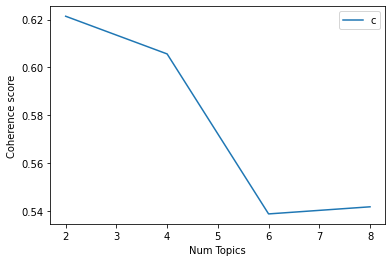

In [ ]:
# Show graph
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [36]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

NameError: name 'model_list' is not defined

In [384]:
df1[df1['sum']==2]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,0036621e4c7e10b5,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,00686325bcc16080,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...
159253,fae97a014c011e3a,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,fc3a75b57f1f6923,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,fdce660ddcd6d7ca,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [430]:
print(df1.loc[[51]])
df1['comment_text'][51]


                  id                                       comment_text  \
51  001dc38a83d420cf  GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  sum  
51      1             0        1       0       0              0    2  


"GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!"

In [432]:
#  predicting comment which is in dataframe  
new_text_corpus =  id2word.doc2bow(df1['comment_text'][51].split())
lda_model[new_text_corpus]
#lda_model.get_document_topics(corpus, minimum_probability=0.0)

[(0, 0.5), (1, 0.5)]

In [467]:
#  predicting comment which is in dataframe  
new_text_corpus_alt =  id2word_alt.doc2bow(df1['comment_text'][79].split())
lda_model_alt[new_text_corpus_alt][0]
#lda_model.get_document_topics(corpus, minimum_probability=0.0)

[(0, 0.14084716),
 (1, 0.5718114),
 (2, 0.0597825),
 (3, 0.034920685),
 (4, 0.12619951),
 (5, 0.06643876)]

In [468]:
# Vocabulary with weights from the model

vocabulary_1_alt = []
k = 0
for i in lda_model_alt.show_topics(formatted=False,num_topics=lda_model_alt.num_topics,num_words=len(lda_model_alt.id2word)):
    lst = []
    for j in i[1]:
        vocabulary_1_alt.append(j[0])

In [213]:
lda_model.show_topics(num_topics=lda_model.num_topics)

[(0,
  '0.084*"nigger" + 0.021*"cunt" + 0.019*"stupid" + 0.014*"cocksucker" + 0.013*"mothjer_fucker" + 0.011*"huge_faggot" + 0.011*"retarded" + 0.008*"aids_aids" + 0.007*"delanoy" + 0.007*"persian"'),
 (1,
  '0.208*"fuck" + 0.064*"shit" + 0.045*"ass" + 0.039*"go" + 0.030*"faggot" + 0.028*"bitch" + 0.017*"dickhead" + 0.013*"shut" + 0.011*"bastard_pro" + 0.011*"assad_hanibal"'),
 (2,
  '0.031*"talk" + 0.030*"page" + 0.017*"please" + 0.013*"wikipedia" + 0.013*"get" + 0.010*"stop" + 0.008*"block" + 0.007*"hi_moron" + 0.007*"pages" + 0.007*"right"'),
 (3,
  '0.058*"suck" + 0.028*"gay" + 0.024*"cock" + 0.023*"fucking" + 0.017*"like" + 0.017*"dick" + 0.015*"eat" + 0.012*"pussy" + 0.012*"mother" + 0.011*"die"'),
 (4,
  '0.058*"hate" + 0.021*"know" + 0.020*"nipple_nipple" + 0.018*"dog" + 0.009*"sucks_cocks" + 0.009*"piece" + 0.009*"fggt" + 0.009*"category" + 0.005*"regards" + 0.005*"placed"'),
 (5,
  '0.013*"article" + 0.008*"wikipedia" + 0.008*"would" + 0.007*"like" + 0.007*"page" + 0.007*"one

In [435]:
lda_model_alt.show_topics(num_topics=lda_model_alt.num_topics)

[(0,
  '0.070*"hate" + 0.028*"dog" + 0.020*"like" + 0.018*"cocksucker" + 0.016*"mothjer_fucker" + 0.011*"bastard_pro_assad_hanibal" + 0.007*"fucking" + 0.005*"people" + 0.005*"page" + 0.003*"jews"'),
 (1,
  '0.016*"wikipedia" + 0.014*"suck" + 0.010*"page" + 0.010*"like" + 0.008*"people" + 0.008*"stupid" + 0.007*"article" + 0.007*"one" + 0.006*"stop" + 0.006*"know"'),
 (2,
  '0.031*"ass" + 0.026*"bitch" + 0.018*"cock" + 0.017*"asshole" + 0.014*"get" + 0.012*"fucking" + 0.010*"pussy" + 0.009*"cunt" + 0.009*"shit" + 0.009*"piece"'),
 (3,
  '0.233*"fuck" + 0.062*"go" + 0.038*"fag" + 0.017*"fucking" + 0.017*"shut" + 0.016*"idiot" + 0.013*"hell" + 0.011*"dog" + 0.010*"god" + 0.010*"hi_moron_hi_moron"'),
 (4,
  '0.032*"jew_fat_jew_fat" + 0.023*"know" + 0.015*"dickhead" + 0.011*"moron" + 0.010*"fucking" + 0.010*"get" + 0.010*"moron_hi_moron_hi" + 0.010*"nipple_nipple_nipple_nipple" + 0.009*"fggt" + 0.009*"fat_jew_fat_jew"'),
 (5,
  '0.082*"nigger" + 0.081*"shit" + 0.041*"fucking" + 0.037*"die"

In [469]:
#Unique words from vocabulary_1_alt
model_vocabulary = list(set(vocabulary_1_alt))


In [470]:
# Weights per topic from model
b_lst = []
for i in lda_model_alt.show_topics(formatted=False,num_topics=lda_model_alt.num_topics,num_words=len(lda_model_alt.id2word)):
    lst = []
    for j in i[1]:
        lst.append(j)
    b_lst.append(lst)
df3 = pd.DataFrame(b_lst)


In [471]:
df_t = df3.transpose()
df_w = pd.DataFrame()
for i in range(6):
    df_s = df_t.loc[df_t[i].str[0].argsort()]
    df_w[i] = df_s[i].values

df_w


,0,1,2,3,4,5
0,"(a_hole, 2.105278e-06)","(a_hole, 8.4433697e-07)","(a_hole, 5.1103557e-06)","(a_hole, 4.7462245e-06)","(a_hole, 5.5924825e-06)","(a_hole, 4.0121326e-06)"
1,"(aa, 2.4953692e-06)","(aa, 1.1889997e-06)","(aa, 5.550442e-06)","(aa, 5.333961e-06)","(aa, 0.00020468376)","(aa, 4.2049064e-06)"
2,"(aaa, 7.106118e-06)","(aaa, 5.061222e-06)","(aaa, 3.231042e-05)","(aaa, 5.4044644e-06)","(aaa, 9.491447e-06)","(aaa, 1.0435419e-05)"
3,"(aaaa, 2.105345e-06)","(aaaa, 8.443485e-07)","(aaaa, 5.110125e-06)","(aaaa, 4.746114e-06)","(aaaa, 5.5926553e-06)","(aaaa, 4.011935e-06)"
4,"(aaaaa, 2.1055007e-06)","(aaaaa, 8.444456e-07)","(aaaaa, 5.1102115e-06)","(aaaaa, 4.746186e-06)","(aaaaa, 5.5930145e-06)","(aaaaa, 4.0119853e-06)"
...,...,...,...,...,...,...
32300,"(迷惑, 2.5091447e-06)","(迷惑, 9.887135e-07)","(迷惑, 5.8494775e-06)","(迷惑, 5.3799595e-06)","(迷惑, 6.3266557e-06)","(迷惑, 4.4505423e-06)"
32301,"(連絡, 2.5091447e-06)","(連絡, 9.887135e-07)","(連絡, 5.8494775e-06)","(連絡, 5.3799595e-06)","(連絡, 6.3266557e-06)","(連絡, 4.4505423e-06)"
32302,"(ａｎｏｎｔａｌｋ, 2.105252e-06)","(ａｎｏｎｔａｌｋ, 8.442632e-07)","(ａｎｏｎｔａｌｋ, 5.1100615e-06)","(ａｎｏｎｔａｌｋ, 4.7460485e-06)","(ａｎｏｎｔａｌｋ, 5.592317e-06)","(ａｎｏｎｔａｌｋ, 4.011949e-06)"
32303,"(ｃｏｍ, 2.105252e-06)","(ｃｏｍ, 8.442632e-07)","(ｃｏｍ, 5.1100615e-06)","(ｃｏｍ, 4.7460485e-06)","(ｃｏｍ, 5.592317e-06)","(ｃｏｍ, 4.011949e-06)"


In [472]:
# Set vocabulary as index create weight matrix
df_w.set_index(df_w[0].str[0], inplace=True)
for i in range(6):
    df_w[i] = df_w[i].str[1]

df_w

,0,1,2,3,4,5
0,,,,,,
a_hole,0.000002,8.443370e-07,0.000005,0.000005,0.000006,0.000004
aa,0.000002,1.189000e-06,0.000006,0.000005,0.000205,0.000004
aaa,0.000007,5.061222e-06,0.000032,0.000005,0.000009,0.000010
aaaa,0.000002,8.443485e-07,0.000005,0.000005,0.000006,0.000004
aaaaa,0.000002,8.444456e-07,0.000005,0.000005,0.000006,0.000004
...,...,...,...,...,...,...
迷惑,0.000003,9.887135e-07,0.000006,0.000005,0.000006,0.000004
連絡,0.000003,9.887135e-07,0.000006,0.000005,0.000006,0.000004
ａｎｏｎｔａｌｋ,0.000002,8.442632e-07,0.000005,0.000005,0.000006,0.000004


In [473]:
# Distribution matrix for all topics

beta = np.array(df_w.transpose())

In [477]:
# Synthetic sentence generator

alpha = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])
topic_proportions = np.random.dirichlet(alpha)
vocabulary = model_vocabulary

print(beta.shape)
print(len(vocabulary))
lst = []
print(np.round(topic_proportions,4))
for _ in range(np.random.poisson(lam = 50, size = 1)[0]):
    word_topic = random.choices([i for i in range(6)],topic_proportions)
    next_word = random.choices(vocabulary, beta[word_topic[0]])[0]
    lst.append(next_word)
print(lst)

(6, 32305)
32305
[0.1218 0.0858 0.2861 0.0008 0.0016 0.504 ]
['marginalized', 'itallic', 'molestors', 'clio', 'undated', 'noticeably', 'wimps', 'mongolical', 'ngo', 'pattern', 'originating', 'joint', 'heres', 'ghloooooov', 'lieutenant', 'sexuall', 'ghirlor', 'integrat', 'strength', 'nutjob', 'mechanicus', 'amdrew', 'throated', 'scaring', 'stool', 'mongolical', 'becaue', 'asshole', 'devised', 'prime', 'fok', 'sukk', 'assertion', 'mongolical', 'smells', 'reenforces', 'scaring', 'gop', 'choir', 'dickheads', 'exaggerate', 'heart', 'consequences', 'joint', 'favioe', 'gerard', 'reenforces', 'len', 'scaring', 'didand', 'clutching', 'thriving', 'disscusions', 'britannica', 'undated', 'justifying', 'joint', 'zzzz', 'nefuck', 'rainbow', 'scaring', 'thinking', 'afterwards', 'barbs', 'ud', 'wikifools', 'cookie']


In [479]:
new_text_corpus =  id2word_alt.doc2bow(lst)

lda_model_alt[new_text_corpus][0]

[(0, 0.17392243),
 (1, 0.49593973),
 (2, 0.18049541),
 (3, 0.038325377),
 (4, 0.03154884),
 (5, 0.079768226)]

In [518]:
# Copy of Synthetic sentence generator
row = []
for i in range(10000):
    sent = []
    alpha = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])
    topic_proportions = np.random.dirichlet(alpha)
    vocabulary = model_vocabulary

    # print(beta.shape)
    # print(len(vocabulary))
    lst = []
    w = list(np.round(topic_proportions,4))
    sent.append(w)

    for _ in range(np.random.poisson(lam = 30, size = 1)[0]):
        word_topic = random.choices([i for i in range(6)],topic_proportions)
        next_word = random.choices(vocabulary, beta[word_topic[0]])[0]
        lst.append(next_word)
    sent.append(lst)
    row.append(sent)
df_syn = pd.DataFrame(row)
# print (row)
df_syn

,0,1
0,"[0.0, 0.0262, 0.0644, 0.0024, 0.8045, 0.1026]","[cswf, evering, falafel, cswf, bibi, desevere,..."
1,"[0.123, 0.663, 0.0028, 0.006, 0.2028, 0.0024]","[intercouse, unscrupulous, murderers, living, ..."
2,"[0.0527, 0.8545, 0.0257, 0.0164, 0.0, 0.0507]","[kindergarden, undeniably, hunted, pale, ironi..."
3,"[0.0, 0.1597, 0.8339, 0.0063, 0.0, 0.0]","[pyprimes, fok, uploaders, fok, jhas, duol, se..."
4,"[0.0785, 0.8406, 0.0047, 0.0054, 0.0002, 0.0706]","[operations, chukkk, improper, improper, magaw..."
...,...,...
9995,"[0.1218, 0.2217, 0.0021, 0.2637, 0.3378, 0.053]","[ambush, betrays, sed, wimps, ironic, tiptoy, ..."
9996,"[0.0, 0.6537, 0.0021, 0.0, 0.0949, 0.2493]","[achieve, didand, exploits, spew, clowns, vana..."
9997,"[0.0261, 0.8189, 0.1486, 0.0059, 0.0003, 0.0002]","[syndrom, wrna, minority, indigenous, betrays,..."
9998,"[0.6476, 0.0033, 0.0012, 0.0607, 0.1487, 0.1385]","[barbs, ironic, barbs, affront, sodomized, fli..."


In [519]:
lst_test =[]
for row_ind in range(10000):
    new_text_corpus =  id2word_alt.doc2bow(df_syn.iloc[row_ind, 1])
    weight = []
    for i in range(6):
        weight.append(lda_model_alt[new_text_corpus][0][i][1])
    lst_test.append(weight)
# print(lst_test)
    #print(lda_model[new_text_corpus])
# df_syn.iloc[row_ind,2] = lda_model[new_text_corpus]
df_syn[["pred_LDA_tpc_1", "pred_LDA_tpc_2", "pred_LDA_tpc_3", "pred_LDA_tpc_4", "pred_LDA_tpc_5", "pred_LDA_tpc_6"]] = pd.DataFrame(lst_test)
# df_syn["pred_LDA_tpc_1"] = pd.DataFrame(lst_test[0])
df_syn

,0,1,pred_LDA_tpc_1,pred_LDA_tpc_2,pred_LDA_tpc_3,pred_LDA_tpc_4,pred_LDA_tpc_5,pred_LDA_tpc_6
0,"[0.0, 0.0262, 0.0644, 0.0024, 0.8045, 0.1026]","[cswf, evering, falafel, cswf, bibi, desevere,...",0.164041,0.587314,0.055164,0.023175,0.121253,0.049042
1,"[0.123, 0.663, 0.0028, 0.006, 0.2028, 0.0024]","[intercouse, unscrupulous, murderers, living, ...",0.327405,0.332696,0.223577,0.019572,0.053982,0.042788
2,"[0.0527, 0.8545, 0.0257, 0.0164, 0.0, 0.0507]","[kindergarden, undeniably, hunted, pale, ironi...",0.235385,0.391212,0.164483,0.022858,0.135818,0.050278
3,"[0.0, 0.1597, 0.8339, 0.0063, 0.0, 0.0]","[pyprimes, fok, uploaders, fok, jhas, duol, se...",0.339934,0.477136,0.052030,0.024342,0.047535,0.059000
4,"[0.0785, 0.8406, 0.0047, 0.0054, 0.0002, 0.0706]","[operations, chukkk, improper, improper, magaw...",0.261404,0.449845,0.049699,0.090558,0.056213,0.092303
...,...,...,...,...,...,...,...,...
9995,"[0.1218, 0.2217, 0.0021, 0.2637, 0.3378, 0.053]","[ambush, betrays, sed, wimps, ironic, tiptoy, ...",0.295999,0.489400,0.044485,0.020394,0.109279,0.039978
9996,"[0.0, 0.6537, 0.0021, 0.0, 0.0949, 0.2493]","[achieve, didand, exploits, spew, clowns, vana...",0.266967,0.509904,0.116691,0.023961,0.037399,0.045074
9997,"[0.0261, 0.8189, 0.1486, 0.0059, 0.0003, 0.0002]","[syndrom, wrna, minority, indigenous, betrays,...",0.136713,0.506658,0.223328,0.026966,0.047858,0.058489
9998,"[0.6476, 0.0033, 0.0012, 0.0607, 0.1487, 0.1385]","[barbs, ironic, barbs, affront, sodomized, fli...",0.307328,0.492328,0.039564,0.030885,0.090373,0.039607


In [520]:
# Train Model on synthetic data 
syn_data = list(df_syn[1])




In [521]:
# Create Dictionary
id2word_syn = corpora.Dictionary(syn_data)

# filter extrims --> id2word_alt.filter_extremes(no_below=20)

# Create Corpus
texts_syn = syn_data

# Term Document Frequency
corpus_syn = [id2word_syn.doc2bow(text) for text in texts_syn]

# View
print(corpus_syn[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]


In [522]:
# Human readable format of corpus (term-frequency)
[[(id2word_syn[id], freq) for id, freq in cp] for cp in corpus_syn[:1]]

[[('barbs', 1),
  ('bibi', 1),
  ('cooling', 1),
  ('cswf', 2),
  ('desevere', 1),
  ('drama', 1),
  ('dutchman', 1),
  ('evering', 1),
  ('falafel', 1),
  ('flygayguy', 1),
  ('foibles', 1),
  ('frauds', 1),
  ('garasanin', 1),
  ('geniuses', 2),
  ('grrr', 1),
  ('joint', 1),
  ('lagalese', 1),
  ('nationalistic', 1),
  ('normally', 1),
  ('ounce', 1),
  ('parading', 1),
  ('phonics', 1),
  ('puckerd', 1),
  ('referrence', 1),
  ('scar', 1),
  ('souls', 1),
  ('tdadamemd', 1),
  ('undated', 1),
  ('vine', 2),
  ('warrens', 1),
  ('warriors', 1),
  ('wee', 1),
  ('westheimer', 1),
  ('whoever', 1),
  ('worms', 1)]]

In [523]:
# Build LDA model_syn
lda_model_syn = gensim.models.ldamodel.LdaModel(corpus=corpus_syn,
                                           id2word=id2word_syn,
                                           num_topics=6,
                                           random_state=121,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [524]:
new_text_corpus =  id2word_syn.doc2bow(syn_data[3])
lda_model_syn[new_text_corpus][0]
#lda_model.get_document_topics(corpus, minimum_probability=0.0)

[(0, 0.011489408),
 (1, 0.7858364),
 (2, 0.15942861),
 (3, 0.013440555),
 (4, 0.011636003),
 (5, 0.018169072)]

In [537]:
lst_test =[]
for row_ind in range(10000):
    new_text_corpus =  id2word_syn.doc2bow(syn_data[row_ind])
    pred = lda_model_syn[new_text_corpus][0]
    weight = []
    for i in range(6):
        if i in [j[0] for j in pred]:
            weight.append([j[1] for j in pred if i == j[0]][0])
        else: weight.append(0)
    lst_test.append(weight)
# print(lst_test)
    #print(lda_model[new_text_corpus])
# df_syn.iloc[row_ind,2] = lda_model[new_text_corpus]
df_syn[["pred_LDA_tpc_1", "pred_LDA_tpc_2", "pred_LDA_tpc_3", "pred_LDA_tpc_4", "pred_LDA_tpc_5", "pred_LDA_tpc_6"]] = pd.DataFrame(lst_test)
# df_syn["pred_LDA_tpc_1"] = pd.DataFrame(lst_test[0])
df_syn

,0,1,pred_LDA_tpc_1,pred_LDA_tpc_2,pred_LDA_tpc_3,pred_LDA_tpc_4,pred_LDA_tpc_5,pred_LDA_tpc_6
0,"[0.0, 0.0262, 0.0644, 0.0024, 0.8045, 0.1026]","[cswf, evering, falafel, cswf, bibi, desevere,...",0.098601,0.067503,0.110783,0.698851,0.000000,0.014990
1,"[0.123, 0.663, 0.0028, 0.006, 0.2028, 0.0024]","[intercouse, unscrupulous, murderers, living, ...",0.046125,0.013725,0.749637,0.050612,0.086445,0.053457
2,"[0.0527, 0.8545, 0.0257, 0.0164, 0.0, 0.0507]","[kindergarden, undeniably, hunted, pale, ironi...",0.102951,0.011769,0.724202,0.011665,0.102686,0.046726
3,"[0.0, 0.1597, 0.8339, 0.0063, 0.0, 0.0]","[pyprimes, fok, uploaders, fok, jhas, duol, se...",0.011489,0.785836,0.159429,0.013441,0.011636,0.018169
4,"[0.0785, 0.8406, 0.0047, 0.0054, 0.0002, 0.0706]","[operations, chukkk, improper, improper, magaw...",0.012520,0.018935,0.486022,0.054195,0.096189,0.332139
...,...,...,...,...,...,...,...,...
9995,"[0.1218, 0.2217, 0.0021, 0.2637, 0.3378, 0.053]","[ambush, betrays, sed, wimps, ironic, tiptoy, ...",0.089756,0.010252,0.289323,0.176232,0.173363,0.261073
9996,"[0.0, 0.6537, 0.0021, 0.0, 0.0949, 0.2493]","[achieve, didand, exploits, spew, clowns, vana...",0.260631,0.013544,0.541557,0.117423,0.011637,0.055208
9997,"[0.0261, 0.8189, 0.1486, 0.0059, 0.0003, 0.0002]","[syndrom, wrna, minority, indigenous, betrays,...",0.011486,0.191223,0.754195,0.013374,0.011623,0.018100
9998,"[0.6476, 0.0033, 0.0012, 0.0607, 0.1487, 0.1385]","[barbs, ironic, barbs, affront, sodomized, fli...",0.093071,0.046844,0.050459,0.160576,0.439399,0.209651


In [536]:
df_syn

,0,1,pred_LDA_tpc_1,pred_LDA_tpc_2,pred_LDA_tpc_3,pred_LDA_tpc_4,pred_LDA_tpc_5,pred_LDA_tpc_6
0,"[0.0, 0.0262, 0.0644, 0.0024, 0.8045, 0.1026]","[cswf, evering, falafel, cswf, bibi, desevere,...",0.0,0.0,0.0,1.0,0.0,0.0
1,"[0.123, 0.663, 0.0028, 0.006, 0.2028, 0.0024]","[intercouse, unscrupulous, murderers, living, ...",0.0,0.0,1.0,0.0,0.0,0.0
2,"[0.0527, 0.8545, 0.0257, 0.0164, 0.0, 0.0507]","[kindergarden, undeniably, hunted, pale, ironi...",0.0,0.0,1.0,0.0,0.0,0.0
3,"[0.0, 0.1597, 0.8339, 0.0063, 0.0, 0.0]","[pyprimes, fok, uploaders, fok, jhas, duol, se...",0.0,1.0,0.0,0.0,0.0,0.0
4,"[0.0785, 0.8406, 0.0047, 0.0054, 0.0002, 0.0706]","[operations, chukkk, improper, improper, magaw...",1,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
9995,"[0.1218, 0.2217, 0.0021, 0.2637, 0.3378, 0.053]","[ambush, betrays, sed, wimps, ironic, tiptoy, ...",1,0.0,1.0,0.0,0.0,1.0
9996,"[0.0, 0.6537, 0.0021, 0.0, 0.0949, 0.2493]","[achieve, didand, exploits, spew, clowns, vana...",0.0,0.0,1.0,0.0,0.0,0.0
9997,"[0.0261, 0.8189, 0.1486, 0.0059, 0.0003, 0.0002]","[syndrom, wrna, minority, indigenous, betrays,...",0.0,0.0,1.0,0.0,0.0,0.0
9998,"[0.6476, 0.0033, 0.0012, 0.0607, 0.1487, 0.1385]","[barbs, ironic, barbs, affront, sodomized, fli...",1,0.0,0.0,0.0,1.0,1.0


In [538]:
# Convert Scores
df_score = df_syn
for i in range(1,7):
    df_score.loc[df_score['pred_LDA_tpc_{}'.format(i)]>=0.2, 'pred_LDA_tpc_{}'.format(i)] = 1
    df_score.loc[df_score['pred_LDA_tpc_{}'.format(i)]<0.2, 'pred_LDA_tpc_{}'.format(i)] = 0
df_score

,0,1,pred_LDA_tpc_1,pred_LDA_tpc_2,pred_LDA_tpc_3,pred_LDA_tpc_4,pred_LDA_tpc_5,pred_LDA_tpc_6
0,"[0.0, 0.0262, 0.0644, 0.0024, 0.8045, 0.1026]","[cswf, evering, falafel, cswf, bibi, desevere,...",0.0,0.0,0.0,1.0,0.0,0.0
1,"[0.123, 0.663, 0.0028, 0.006, 0.2028, 0.0024]","[intercouse, unscrupulous, murderers, living, ...",0.0,0.0,1.0,0.0,0.0,0.0
2,"[0.0527, 0.8545, 0.0257, 0.0164, 0.0, 0.0507]","[kindergarden, undeniably, hunted, pale, ironi...",0.0,0.0,1.0,0.0,0.0,0.0
3,"[0.0, 0.1597, 0.8339, 0.0063, 0.0, 0.0]","[pyprimes, fok, uploaders, fok, jhas, duol, se...",0.0,1.0,0.0,0.0,0.0,0.0
4,"[0.0785, 0.8406, 0.0047, 0.0054, 0.0002, 0.0706]","[operations, chukkk, improper, improper, magaw...",0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
9995,"[0.1218, 0.2217, 0.0021, 0.2637, 0.3378, 0.053]","[ambush, betrays, sed, wimps, ironic, tiptoy, ...",0.0,0.0,1.0,0.0,0.0,1.0
9996,"[0.0, 0.6537, 0.0021, 0.0, 0.0949, 0.2493]","[achieve, didand, exploits, spew, clowns, vana...",1.0,0.0,1.0,0.0,0.0,0.0
9997,"[0.0261, 0.8189, 0.1486, 0.0059, 0.0003, 0.0002]","[syndrom, wrna, minority, indigenous, betrays,...",0.0,0.0,1.0,0.0,0.0,0.0
9998,"[0.6476, 0.0033, 0.0012, 0.0607, 0.1487, 0.1385]","[barbs, ironic, barbs, affront, sodomized, fli...",0.0,0.0,0.0,0.0,1.0,1.0
